In [1]:
import uproot
print("uproot version: ", uproot.__version__)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import pickle


uproot version:  5.0.5


# Load Ntuple File

In [2]:
# downloaded from /exp/uboone/data/users/eyandel/combined_reco/mcc910_test/processed_checkout_root_files/MCC9.10_Test_Samples_v10_04_07_04_Run4b_super_unified_reco2_BNB_nu_NC_pi0_overlay_reco2_hist.root
# BNB NC Pi0 super-unified ntuple, with WC post-processing
f = uproot.open("data_files/MCC9.10_Test_Samples_v10_04_07_04_Run4b_super_unified_reco2_BNB_nu_NC_pi0_overlay_reco2_hist.root")

# TODO: make this work nicely with multiple files of different types and runs being loaded together


# Load Wire-Cell Variables

In [3]:
T_bdt_vars = [              # variables involved with BDT training (if you want to train your own BDT, lots of these variables will be useful)
                            # many of these variables describe specific features of the WC spacepoints using this code: https://github.com/BNLIF/wire-cell-pid/blob/master/src/NeutrinoID_nue_tagger.h
                            # here, we just include higher level outputs:
    "nue_score",                    # BDT score for nue selection, used for the WC inclusive nueCC analysis
    "numu_score",                   # BDT score for numu selection, used for the WC inclusive numuCC selections
    "nc_delta_score",               # BDT score for NC Delta selection
    "nc_pio_score",                 # BDT score for NC pi0 selection
    "numu_cc_flag",                 # flag, -1 means not generic selected, 0 means generic selected, 1 means cut-based numuCC selected. We often use "numu_cc_flag >= 0" to apply generic neutrino selection.
]

T_eval_vars = [             # variables involved with low level reconstruction and truth information
    "run",                          # run number
    "subrun",                       # subrun number
    "event",                        # event number
    "match_isFC",                   # reconstructed cluster is fully contained (FC), boolean
    "truth_nuEnergy",               # true neutrino energy (MeV)
    "truth_nuPdg",                  # true neutrino pdg code
    "truth_isCC",                   # true interaction type is charged current, boolean
    "match_completeness_energy",    # the true energy deposited in the clusters that are 3D-matched with the reconstructed neutrino clusters (MeV)
    "truth_energyInside",           # the true energy deposited in the TPC Fiducial Volume (MeV)
    "truth_vtxInside",              # boolean, true neutrino vertex is inside the TPC Fiducial Volume
    "truth_vtxX",                   # true neutrino vertex x (cm)
    "truth_vtxY",                   # true neutrino vertex y (cm)
    "truth_vtxZ",                   # true neutrino vertex z (cm)
    "weight_cv",                    # GENIE MicroBooNE tune event weight (which should be corrected by also using weight_spline)
    "weight_spline",                # additional weight to correct the GENIE tune for certain events
]
T_eval_data_vars = [        # same as above, but for data files we do not attempt to load any truth information
    "run",
    "subrun",
    "event",
    "match_isFC",
]

T_kine_vars = [             # variables involved with kinematic reconstruction
    "kine_reco_Enu",                # reconstructed neutrino energy (MeV). "kine_reco_Enu > 0" is another way to apply generic neutrino selection.
    "kine_energy_particle",         # energy of each reco particle
    "kine_particle_type",           # pdg code of each reco particle
]

T_pf_vars = [               # variables involved with individual particles
    "truth_NprimPio",
    "truth_NCDelta",
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "reco_muonMomentum",            # reconstructed muon momentum 4-vector (p_x, p_y, p_z, p_t), in (GeV/c, GeV/c, GeV/c, GeV)
    "reco_showerMomentum",          # reconstructed primary shower momentum 4-vector (p_x, p_y, p_z, p_t), in (GeV/c, GeV/c, GeV/c, GeV)
    "reco_showervtxX",
    "reco_showervtxY",
    "reco_showervtxZ",

    # These variables are related to individual true particles
    "truth_Ntrack",
    "truth_id",
    "truth_pdg",
    "truth_mother",
    "truth_startMomentum",
    "truth_startXYZT",
    "truth_endXYZT",

    # These variables are related to individual reco particles
    "reco_Ntrack",
    "reco_id",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum",
    "reco_startXYZT",
    "reco_endXYZT",
]

T_pf_data_vars = [          # same as above, but for data files we do not attempt to load any truth information
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "reco_muonMomentum",
    "reco_showerMomentum",
    "reco_showervtxX",
    "reco_showervtxY",
    "reco_showervtxZ",
    "reco_Ntrack",
    "reco_id",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum",
    "reco_startXYZT",
    "reco_endXYZT",
]

vars = {}
vars.update(f["wcpselection"]["T_BDTvars"].arrays(T_bdt_vars, library="np"))
vars.update(f["wcpselection"]["T_eval"].arrays(T_eval_vars, library="np"))
vars.update(f["wcpselection"]["T_KINEvars"].arrays(T_kine_vars, library="np"))
vars.update(f["wcpselection"]["T_PFeval"].arrays(T_pf_vars, library="np"))
file_POT = np.sum(f["wcpselection"]["T_pot"].arrays("pot_tor875good", library="np")["pot_tor875good"])
for col in vars:
    vars[col] = vars[col].tolist()
wc_df = pd.DataFrame(vars)

wc_df


,nue_score,numu_score,nc_delta_score,nc_pio_score,numu_cc_flag,run,subrun,event,match_isFC,truth_nuEnergy,...,truth_startMomentum,truth_startXYZT,truth_endXYZT,reco_Ntrack,reco_id,reco_pdg,reco_mother,reco_startMomentum,reco_startXYZT,reco_endXYZT
0,2.904263,-0.783497,-3.110854,-1.662595,1.0,19774,28,1405,True,944.208313,...,"[[0.32706812, -0.075722165, 0.34179792, 0.4790...","[[49.16814, 48.351692, 649.06793, 3259.3728], ...","[[70586.08, -16238.267, 74163.0, 6696.5513], [...",10,"[38003, 38004, 38001, 37011, 41014, 105015, 38...","[13, 11, 11, 11, 11, 11, 11, 22, 22, 22]","[0, 0, 38003, 37016, 41017, 105018, 0, 38005, ...","[[-0.1541032, 0.045414254, 0.066180594, 0.2033...","[[39.785515, 47.179256, 656.585, 0.0], [39.785...","[[17.282404, 52.31357, 672.04193, 0.0], [42.77..."
1,-15.000000,-1.181833,-8.657757,3.861268,0.0,19774,28,1432,True,680.497375,...,"[[0.094217375, 0.2519559, 0.12018718, 0.294624...","[[116.51252, 94.04743, 188.02686, 3489.1284], ...","[[19953.69, 53000.0, 25424.232, 5552.686], [11...",8,"[30013, 27007, 28003, 34018, 27022, 27023, 280...","[2212, 11, 11, 11, 111, 22, 22, 22]","[0, 27023, 28024, 34025, 30013, 27022, 27022, ...","[[0.3399893, 0.2502075, 0.09915741, 1.0336262]...","[[112.47752, 91.24976, 186.86684, 0.0], [117.8...","[[117.877625, 93.10756, 188.86464, 0.0], [116...."
2,-10.339163,-1.903668,-0.562459,1.155790,0.0,19774,28,1436,True,724.086121,...,"[[-0.09895344, -0.055159964, 0.18558961, 0.217...","[[254.09789, -30.886377, 272.97333, 3645.886],...","[[-39251.08, -21994.352, 74163.0, 6533.509], [...",19,"[42001, 46004, 44002, 47005, 48006, 49007, 500...","[11, 11, 2212, 2212, 11, 11, 11, 2212, 11, 111...","[42018, 46019, 44020, 47021, 48022, 49023, 500...","[[0.12717538, 0.008148999, 0.035806287, 0.1323...","[[189.85085, -43.40719, 260.26495, 0.0], [133....","[[253.8198, -29.627752, 286.1985, 0.0], [131.3..."
3,-15.000000,0.510881,-6.701344,1.967854,0.0,19774,28,1437,False,1252.332275,...,"[[0.1310195, 0.34095842, 0.4759327, 0.59994227...","[[232.68335, 49.032757, 41.788048, 4605.279], ...","[[20634.906, 53000.0, 73949.1, 7713.055], [219...",12,"[21009, 21017, 24004, 23011, 22010, 26013, 270...","[2212, 13, 11, 11, 11, 11, 2212, 22, 22, 22, 2...","[0, 0, 24018, 23019, 22020, 26021, 27022, 0, 0...","[[-0.27292582, -0.3239041, 0.49821973, 1.14366...","[[232.36584, 49.02663, 42.13049, 0.0], [232.36...","[[219.2701, 39.888496, 63.012775, 0.0], [231.9..."
4,-15.000000,0.042439,-1.286467,1.467722,1.0,19774,28,1449,True,1806.759644,...,"[[-0.13275962, 0.30879852, 0.7966364, 0.864645...","[[102.66803, -115.307655, 975.60364, 3730.9536...","[[-12127.078, 28253.91, 74163.0, 6380.628], [1...",12,"[39002, 39001, 151028, 43012, 149026, 152029, ...","[13, 11, 11, 11, 11, 11, 11, 22, 22, 22, 22, 22]","[0, 0, 151032, 43033, 149034, 152035, 45036, 0...","[[0.066122875, -0.13856469, -0.07525385, 0.200...","[[90.01723, -76.88051, 1007.078, 0.0], [90.017...","[[96.84053, -98.395454, 992.0257, 0.0], [88.66..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11930,-15.000000,0.668128,-2.525500,-0.500966,0.0,19899,256,12838,False,786.048889,...,"[[0.05659127, 0.13554163, 0.417019, 0.44213003...","[[244.39944, 41.537846, 127.5906, 3875.933], [...","[[10318.382, 24108.518, 74163.0, 6494.2373], [...",19,"[25013, 34039, 91043, 26007, 27016, 28019, 350...","[13, 11, 11, 11, 11, 11, 11, 2212, 2212, 11, 2...","[0, 34047, 91048, 26049, 27050, 28051, 35052, ...","[[-0.06259094, 0.0066522243, -0.058904696, 0.1...","[[229.65771, 57.862804, 90.83, 0.0], [251.3243...","[[226.37854, 58.525738, 87.31212, 0.0], [254.5..."
11931,-15.000000,-3.821578,-2.275953,-1.729817,-1.0,19899,256,12840,True,1108.097900,...,"[[-0.49169856, -0.007367736, 0.24492505, 0.549...","[[202.11443, -1.0341694, 245.16676, 4306.6367]...","[[-74364.25, -1113.0227, 37286.285, 7078.0], [...",0,[],[],[],[],[],[]
11932,-9.055404,0.208738,-4.391432,1.649163,0.0,19899,256,12841,True,1314.163208,...,"[[-0.06927637, -0.0660492

## Wire-Cell post-processing

In [4]:
# Extra reco variables
proton_nums = []
other_track_nums = []
energy_lists = wc_df["kine_energy_particle"].to_numpy()
pdg_lists = wc_df["kine_particle_type"].to_numpy()
for i in tqdm(range(wc_df.shape[0])):
    proton_num = 0
    other_track_num = 0
    energy_list = energy_lists[i]
    pdg_list = pdg_lists[i]
    for i in range(len(energy_list)):
        if abs(pdg_list[i]) == 2212:
            if energy_list[i] > 35: # 35 MeV reco proton kinetic energy threshold
                proton_num += 1
        if abs(pdg_list[i]) == 13 or abs(pdg_list[i]) == 211: # see N_tracks at https://github.com/BNLIF/wcp-uboone-bdt/blob/main/inc/WCPLEEANA/cuts.h
            if energy_list[i] > 10.:
                other_track_num += 1
    proton_nums.append(proton_num)
    other_track_nums.append(other_track_num)
wc_df["reco_num_protons"] = proton_nums
wc_df["reco_num_other_tracks"] = other_track_nums

# Extra truth variables
max_prim_proton_energies = []
truth_pdgs = wc_df["truth_pdg"].to_numpy()
truth_mothers = wc_df["truth_mother"].to_numpy()
truth_startMomentums = wc_df["truth_startMomentum"].to_numpy()
for i in tqdm(range(wc_df.shape[0])):
    max_prim_proton_energy = 0
    truth_pdg_list = truth_pdgs[i]
    truth_mother_list = truth_mothers[i]
    truth_startMomentum_list = truth_startMomentums[i]
    if isinstance(truth_pdg_list, float) and np.isnan(truth_pdg_list): # doesn't have a truth Geant4 particle tree
        max_prim_proton_energies.append(-1)
        continue
    for j in range(len(truth_pdg_list)):
        if truth_mother_list[j] == 0 and truth_pdg_list[j] == 2212: # primary proton
            max_prim_proton_energy = max(truth_startMomentum_list[j][3] * 1000. - 938.272089, max_prim_proton_energy)
    max_prim_proton_energies.append(max_prim_proton_energy)
wc_df["true_max_prim_proton_energy"] = max_prim_proton_energies

# extra primary shower position and angle variables
shower_thetas = []
shower_phis = []
distances_to_boundary = []
backwards_projected_dists = []
reco_shower_momentum = wc_df["reco_showerMomentum"].to_numpy()
reco_nu_vtx_x = wc_df["reco_showervtxX"].to_numpy()
reco_nu_vtx_y = wc_df["reco_showervtxY"].to_numpy()
reco_nu_vtx_z = wc_df["reco_showervtxZ"].to_numpy()
for i in tqdm(range(wc_df.shape[0])):
    reco_shower_momentum_0 = reco_shower_momentum[i][0]
    reco_shower_momentum_1 = reco_shower_momentum[i][1]
    reco_shower_momentum_2 = reco_shower_momentum[i][2]
    reco_shower_momentum_3 = reco_shower_momentum[i][3]
    if reco_shower_momentum_3 > 0:
        reco_shower_momentum_perp = np.sqrt(reco_shower_momentum_0 * reco_shower_momentum_0 + reco_shower_momentum_1 * reco_shower_momentum_1)
        shower_thetas.append(np.arctan2(reco_shower_momentum_perp, reco_shower_momentum_2) * 180. / np.pi)
        shower_phis.append(np.arctan2(reco_shower_momentum_0, reco_shower_momentum_1) * 180. / np.pi)

        shower_momentum_total_3d = np.sqrt(reco_shower_momentum_0 * reco_shower_momentum_0 + 
                                            reco_shower_momentum_1 * reco_shower_momentum_1 + 
                                            reco_shower_momentum_2 * reco_shower_momentum_2)
        shower_unit_vector_3d = [reco_shower_momentum_0 / shower_momentum_total_3d, 
                                    reco_shower_momentum_1 / shower_momentum_total_3d, 
                                    reco_shower_momentum_2 / shower_momentum_total_3d]
        center_x = 130.
        center_y = 0.
        center_z = 525.    
        towards_center_length = np.sqrt((reco_nu_vtx_x[i] - center_x) * (reco_nu_vtx_x[i] - center_x) + 
                                        (reco_nu_vtx_y[i] - center_y) * (reco_nu_vtx_y[i] - center_y) + 
                                        (reco_nu_vtx_z[i] - center_z) * (reco_nu_vtx_z[i] - center_z))
        towards_center_unit_vector_3d = [(center_x - reco_nu_vtx_x[i]) / towards_center_length, 
                                            (center_y - reco_nu_vtx_y[i]) / towards_center_length, 
                                            (center_z - reco_nu_vtx_z[i]) / towards_center_length]

        shower_momentum_total_2d = np.sqrt(reco_shower_momentum_0 * reco_shower_momentum_0 + 
                                            reco_shower_momentum_1 * reco_shower_momentum_1)
        shower_unit_vector_2d = [reco_shower_momentum_0 / shower_momentum_total_3d, 
                                    reco_shower_momentum_1 / shower_momentum_total_3d]
        towards_center_length = np.sqrt((reco_nu_vtx_x[i] - center_x) * (reco_nu_vtx_x[i] - center_x) + 
                                        (reco_nu_vtx_y[i] - center_y) * (reco_nu_vtx_y[i] - center_y))
        towards_center_unit_vector_2d = [(center_x - reco_nu_vtx_x[i]) / towards_center_length, 
                                            (center_y - reco_nu_vtx_y[i]) / towards_center_length]
        
        min_backwards_projected_dist = 1e9
                
        # projecting to x walls
        if shower_unit_vector_3d[0] > 0:
            min_backwards_projected_dist = min(min_backwards_projected_dist, (reco_nu_vtx_x[i] - (-1)) / shower_unit_vector_3d[0])
        else:
            min_backwards_projected_dist = min(min_backwards_projected_dist, (reco_nu_vtx_x[i] - (254.3)) / shower_unit_vector_3d[0])
            
        # projecting to y walls
        if shower_unit_vector_3d[1] > 0:
            min_backwards_projected_dist = min(min_backwards_projected_dist, (reco_nu_vtx_y[i] - (-115.)) / shower_unit_vector_3d[1])
        else:
            min_backwards_projected_dist = min(min_backwards_projected_dist, (reco_nu_vtx_y[i] - (117.)) / shower_unit_vector_3d[1])
            
        # projecting to z walls
        if shower_unit_vector_3d[2] > 0:
            min_backwards_projected_dist = min(min_backwards_projected_dist, (reco_nu_vtx_z[i] - (0.6)) / shower_unit_vector_3d[2])
        else:
            min_backwards_projected_dist = min(min_backwards_projected_dist, (reco_nu_vtx_z[i] - (1036.4)) / shower_unit_vector_3d[2])

        backwards_projected_dists.append(min_backwards_projected_dist)
        
    else:
        shower_thetas.append(np.nan)
        shower_phis.append(np.nan)
        backwards_projected_dists.append(np.nan)
        
    distances_to_boundary.append(np.min([
        abs(reco_nu_vtx_x[i] - (-1.)),
        abs(reco_nu_vtx_x[i] - (254.3)),
        abs(reco_nu_vtx_y[i] - (-115.)),
        abs(reco_nu_vtx_y[i] - (117.)),
        abs(reco_nu_vtx_z[i] - (0.6)),
        abs(reco_nu_vtx_z[i] - (1036.4))
    ]))
wc_df["reco_shower_theta"] = shower_thetas
wc_df["reco_shower_phi"] = shower_phis
wc_df["reco_distance_to_boundary"] = distances_to_boundary
wc_df["reco_backwards_projected_dist"] = backwards_projected_dists


  0%|          | 0/11935 [00:00<?, ?it/s]

  0%|          | 0/11935 [00:00<?, ?it/s]

  0%|          | 0/11935 [00:00<?, ?it/s]

/var/folders/yg/3cj9svrx2kz3bpv_6thtt7x00000gn/T/ipykernel_74673/3936279833.py:104: RuntimeWarning: divide by zero encountered in double_scalars
  min_backwards_projected_dist = min(min_backwards_projected_dist, (reco_nu_vtx_z[i] - (1036.4)) / shower_unit_vector_3d[2])


# Load Blip Variables

In [5]:
blip_vars = [
    "nblips_saved",
    "blip_x",
    "blip_y",
    "blip_z",
    "blip_size",
    "blip_energy",
    "blip_charge",
    "blip_nplanes",
    "blip_proxtrkdist",
    "blip_proxtrkid",
    "blip_touchtrk",
    "blip_touchtrkid",
    "blip_badwirefrac",
    "blip_pl0_nwires",
    "blip_pl1_nwires",
    "blip_pl2_nwires",
    "blip_pl0_bydeadwire",
    "blip_pl1_bydeadwire",
    "blip_pl2_bydeadwire",
    "blip_pl0_centerwire",
    "blip_pl1_centerwire",
    "blip_pl2_centerwire",
    "blip_true_g4id",
    "blip_true_pdg",
    "blip_true_energy",
]

vars = {}
vars.update(f["nuselection"]["NeutrinoSelectionFilter"].arrays(blip_vars, library="np"))
for col in vars:
    vars[col] = vars[col].tolist()
blip_df = pd.DataFrame(vars)

blip_df

,nblips_saved,blip_x,blip_y,blip_z,blip_size,blip_energy,blip_charge,blip_nplanes,blip_proxtrkdist,blip_proxtrkid,...,blip_pl2_nwires,blip_pl0_bydeadwire,blip_pl1_bydeadwire,blip_pl2_bydeadwire,blip_pl0_centerwire,blip_pl1_centerwire,blip_pl2_centerwire,blip_true_g4id,blip_true_pdg,blip_true_energy
0,3,"[5.47, 7.82, 12.36]","[18.36, 20.1, 47.77]","[654.3, 654.7, 675.23]","[3.62, 0.98, 0.87]","[11.146, 2.759, 2.887]","[275650.0, 68220.0, 71390.0]","[3, 3, 2]","[9.405488, 6.5920987, 30.577347]","[2, 2, 2]",...,"[3, 1, 2]","[False, False, False]","[False, False, False]","[False, False, False]","[1376, 1371, 1326]","[1476, 1481, -999]","[2180, 2182, 2250]","[263, 267, 619]","[11, 11, 11]","[2.37, 2.934, 3.048]"
1,6,"[122.11, 116.67, 127.42, 84.41, 81.0, 88.35]","[90.73, 24.09, 18.08, 92.74, 96.1, 96.28]","[137.98, 140.31, 162.09, 134.72, 146.82, 155.52]","[0.5, 4.18, 1.06, 1.99, 0.5, 0.77]","[0.438, 10.118, 1.182, 4.52, 0.656, 1.946]","[10820.0, 250200.0, 29220.0, 111790.0, 16220.0...","[2, 2, 2, 3, 2, 2]","[-9.0, -9.0, -9.0, -9.0, -9.0, -9.0]","[-9, -9, -9, -9, -9, -9]",...,"[1, 9, 1, 5, 1, 2]","[False, False, False, True, False, False]","[False, False, False, False, False, False]","[False, False, False, True, False, False]","[-999, -999, -999, 297, -999, -999]","[821, 631, 648, 823, 853, 868]","[460, 469, 541, 449, 489, 518]","[-9, 311, 102, 234, 258, 254]","[-9, 11, 11, 11, 11, 11]","[-9.0, 10.883, 2.101, 4.824, 0.951, 2.466]"
2,7,"[171.48, 175.61, 248.77, 231.97, 231.66, 252.4...","[-37.42, -9.59, -40.6, -64.55, -17.41, -33.23,...","[268.93, 277.53, 292.17, 336.66, 338.7, 272.98...","[0.82, 0.82, 0.85, 1.05, 1.45, 0.84, 1.45]","[0.55, 1.076, 1.191, 1.754, 7.495, 1.978, 4.542]","[13590.0, 26600.0, 29460.0, 43370.0, 185340.0,...","[2, 3, 3, 3, 3, 2, 2]","[-9.0, -9.0, -9.0, -9.0, -9.0, -9.0, -9.0]","[-9, -9, -9, -9, -9, -9, -9]",...,"[1, 2, 2, 3, 4, 2, 3]","[False, False, False, False, False, False, False]","[False, False, False, False, False, False, False]","[False, False, True, False, False, False, False]","[-999, 832, 934, 1071, 951, -999, -999]","[675, 762, 710, 721, 848, 698, 634]","[895, 923, 973, 1121, 1128, 909, 872]","[403, 392, 60, 1378, 157, 2, 288]","[11, 11, 11, 11, 2212, 2212, 11]","[1.079, 1.346, 1.379, 1.203, 27.771, 12.869, 4..."
3,7,"[209.08, 254.22, 231.18, 225.06, 225.05, 226.1...","[48.13, -57.37, 59.01, 105.4, 107.6, 111.08, -...","[35.64, 42.23, 49.27, 113.38, 114.32, 116.51, ...","[0.59, 1.05, 3.36, 0.81, 1.6, 2.31, 1.12]","[0.691, 1.585, 2.512, 0.979, 3.065, 9.187, 2.083]","[17080.0, 39200.0, 62110.0, 24210.0, 75790.0, ...","[2, 2, 2, 2, 2, 2, 2]","[20.235506, 103.39337, 11.804422, 79.46717, 81...","[1, 1, 1, 1, 1, 1, 1]",...,"[1, 2, 4, 1, 3, 5, 2]","[False, False, False, False, False, False, False]","[False, False, False, False, False, False, False]","[False, False, True, False, False, False, False]","[269, -999, -999, 237, -999, -999, -999]","[-999, 250, 584, -999, 821, 834, 222]","[129, 155, 173, 379, 382, 389, 146]","[-9, 79, 22, -9, 330, 330, 462]","[-9, 2212, 11, -9, -11, -11, 11]","[-9.0, 16.072, 42.705, -9.0, 34.15, 34.15, 2.528]"
4,5,"[95.65, 85.09, 87.95, 81.14, 78.97]","[-67.73, -72.56, -71.08, -78.5, -45.35]","[1028.46, 1008.44, 1008.79, 1022.85, 1026.49]","[0.85, 1.17, 2.42, 1.08, 3.84]","[0.797, 3.65, 9.281, 0.594, 27.123]","[19710.0, 90260.0, 229530.0, 14680.0, 670740.0]","[3, 3, 2, 2, 2]","[39.752243, 29.889416, 32.138416, 21.975954, 5...","[0, 0, 0, 0, 0]",...,"[1, 3, 4, 1, 9]","[False, False, False, False, True]","[False, False, True, False, False]","[False, False, False, True, False]","[2247, 2226, -999, -999, 2180]","[1851, 1804, 1809, 1811, -999]","[3427, 3359, 3360, 3408, 3421]","[1300, -9, 1119, 1416, 1153]","[11, -9, 11, 11, 11]","[1.563, -9.0, 3.74, 2.076, 21.856]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11930,26,"[188.59, 192.7, 179.71, 186.0, 214.29, 115.09,...","[106.13, -96.66, -105.18, -96.85, 106.91, 12.9...","[275.23, 280.01, 

# Load PeLEE Variables

In [6]:
# TODO: add relevant variables here

pelee_vars = [
    "shr_energy",
]

vars = {}
vars.update(f["nuselection"]["NeutrinoSelectionFilter"].arrays(pelee_vars, library="np"))
for col in vars:
    vars[col] = vars[col].tolist()
pelee_df = pd.DataFrame(vars)

pelee_df


,shr_energy
0,0.055183
1,0.066884
2,0.106594
3,0.076399
4,0.000000
...,...
11930,0.315117
11931,0.000000
11932,0.059571
11933,0.044779


In [7]:
# TODO: add LANTERN variables here once they're in the super-unified ntuple
# (LArPID variables are already available in the WC particle flow tree)


# Unifying different reconstructions

In [8]:
# adding variable name prefixes
wc_df = wc_df.add_prefix("wc_")
# blip variables pretty much already have the "blip_" prefix
pelee_df = pelee_df.add_prefix("pelee_")

all_df = pd.concat([wc_df, blip_df, pelee_df], axis=1)

all_df


,wc_nue_score,wc_numu_score,wc_nc_delta_score,wc_nc_pio_score,wc_numu_cc_flag,wc_run,wc_subrun,wc_event,wc_match_isFC,wc_truth_nuEnergy,...,blip_pl0_bydeadwire,blip_pl1_bydeadwire,blip_pl2_bydeadwire,blip_pl0_centerwire,blip_pl1_centerwire,blip_pl2_centerwire,blip_true_g4id,blip_true_pdg,blip_true_energy,pelee_shr_energy
0,2.904263,-0.783497,-3.110854,-1.662595,1.0,19774,28,1405,True,944.208313,...,"[False, False, False]","[False, False, False]","[False, False, False]","[1376, 1371, 1326]","[1476, 1481, -999]","[2180, 2182, 2250]","[263, 267, 619]","[11, 11, 11]","[2.37, 2.934, 3.048]",0.055183
1,-15.000000,-1.181833,-8.657757,3.861268,0.0,19774,28,1432,True,680.497375,...,"[False, False, False, True, False, False]","[False, False, False, False, False, False]","[False, False, False, True, False, False]","[-999, -999, -999, 297, -999, -999]","[821, 631, 648, 823, 853, 868]","[460, 469, 541, 449, 489, 518]","[-9, 311, 102, 234, 258, 254]","[-9, 11, 11, 11, 11, 11]","[-9.0, 10.883, 2.101, 4.824, 0.951, 2.466]",0.066884
2,-10.339163,-1.903668,-0.562459,1.155790,0.0,19774,28,1436,True,724.086121,...,"[False, False, False, False, False, False, False]","[False, False, False, False, False, False, False]","[False, False, True, False, False, False, False]","[-999, 832, 934, 1071, 951, -999, -999]","[675, 762, 710, 721, 848, 698, 634]","[895, 923, 973, 1121, 1128, 909, 872]","[403, 392, 60, 1378, 157, 2, 288]","[11, 11, 11, 11, 2212, 2212, 11]","[1.079, 1.346, 1.379, 1.203, 27.771, 12.869, 4...",0.106594
3,-15.000000,0.510881,-6.701344,1.967854,0.0,19774,28,1437,False,1252.332275,...,"[False, False, False, False, False, False, False]","[False, False, False, False, False, False, False]","[False, False, True, False, False, False, False]","[269, -999, -999, 237, -999, -999, -999]","[-999, 250, 584, -999, 821, 834, 222]","[129, 155, 173, 379, 382, 389, 146]","[-9, 79, 22, -9, 330, 330, 462]","[-9, 2212, 11, -9, -11, -11, 11]","[-9.0, 16.072, 42.705, -9.0, 34.15, 34.15, 2.528]",0.076399
4,-15.000000,0.042439,-1.286467,1.467722,1.0,19774,28,1449,True,1806.759644,...,"[False, False, False, False, True]","[False, False, True, False, False]","[False, False, False, True, False]","[2247, 2226, -999, -999, 2180]","[1851, 1804, 1809, 1811, -999]","[3427, 3359, 3360, 3408, 3421]","[1300, -9, 1119, 1416, 1153]","[11, -9, 11, 11, 11]","[1.563, -9.0, 3.74, 2.076, 21.856]",0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11930,-15.000000,0.668128,-2.525500,-0.500966,0.0,19899,256,12838,False,786.048889,...,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[-999, 1060, 1091, 1088, -999, 842, 1036, 757,...","[1083, 544, 524, 567, 1124, 904, 715, 1051, 10...","[917, 932, 944, 984, 1004, 1074, 1080, 1137, 1...","[-9, 830, 949, 831, -9, 1370, -9, 304, 2481, 2...","[-9, 11, 11, 11, -9, 11, -9, 11, 11, 11, -9, 1...","[-9.0, 1.852, 1.762, 1.384, -9.0, 1.114, -9.0,...",0.315117
11931,-15.000000,-3.821578,-2.275953,-1.729817,-1.0,19899,256,12840,True,1108.097900,...,"[False, False, False]","[False, False, False]","[False, True, False]","[-999, 747, 673]","[1125, 1267, 1305]","[1633, 1345, 1308]","[-9, 5, 280]","[-9, 2212, 11]","[-9.0, 75.982, 0.924]",0.000000
11932,-9.055404,0.208738,-4.391432,1.649163,0.0,19899,256,12841,True,1314.163208,...,"[False, False, False, False, False, False, False]","[False, False, False, False, False, False, False]","[False, False, False, False, False, False, False]","[-999, 1720, 1724, 1727, 1846, 1850, 1515]","[1957, 1737, 1744, -999, 1789, 1785, -999]","[2632, 2789, 2796, 2802, 2964, 2963, 2767]","[-9, 506, 470, 471, -9, -9, 324]","[-9, 11, 11, 11, -9, -9, 11]","[-9.0, 12.583, 6.52, 1.12, -9.0, -9.0, 0.939]",0.059571
11933,-14.410522,-1.838789,-8.202514,3.819379,0.0,19899,256,12845,True,861.936707,...,"[False, False, False]","[False, False, False]","[False, False, False]","[1098, -

# Assigning XS and POT weighting, using WC variables

In [9]:
normalizing_POT = 6.80e20

weight_cv_arr = all_df["wc_weight_cv"]
weight_spline_arr = all_df["wc_weight_spline"]
net_weights = []
for i in tqdm(range(len(weight_cv_arr))):
    weight_temp = weight_cv_arr[i] * weight_spline_arr[i]
    if weight_temp <= 0. or weight_temp > 30. or np.isnan(weight_temp): # something went wrong with the saved GENIE weights, set it to one
        weight_temp = 1.
    net_weights.append(weight_temp * normalizing_POT / file_POT)
all_df["net_weight"] = net_weights


  0%|          | 0/11935 [00:00<?, ?it/s]

# Saving to pickle

In [10]:
all_df.to_pickle("data_files/all_df.pkl")

# to load:
# all_df = pd.read_pickle("data_files/all_df.pkl")


# Making Histograms

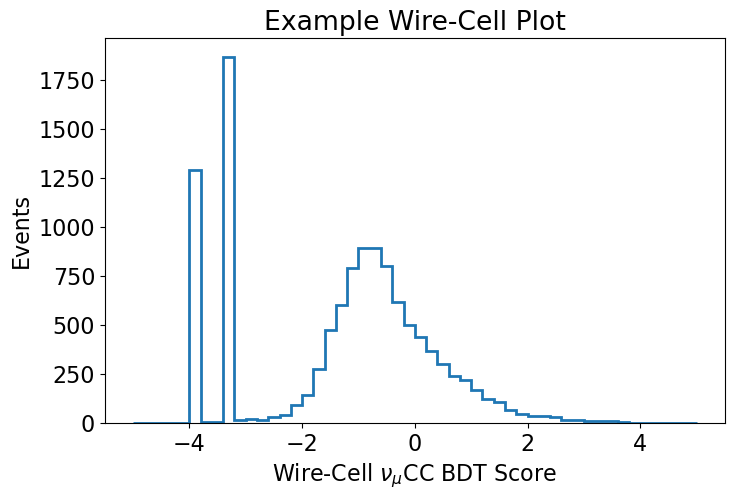

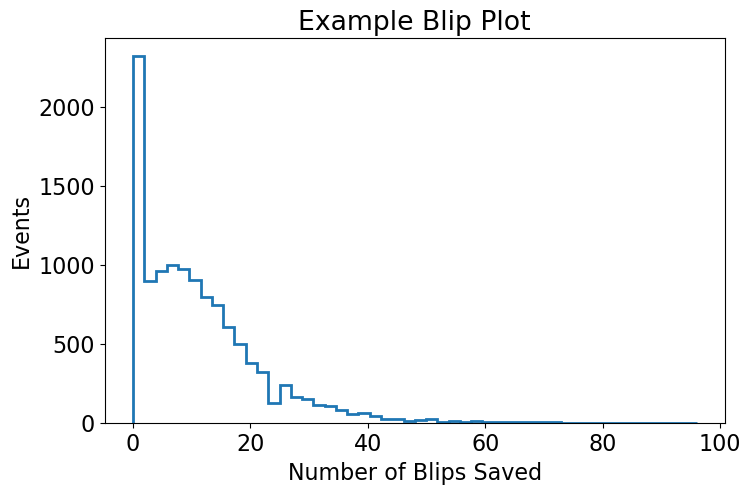

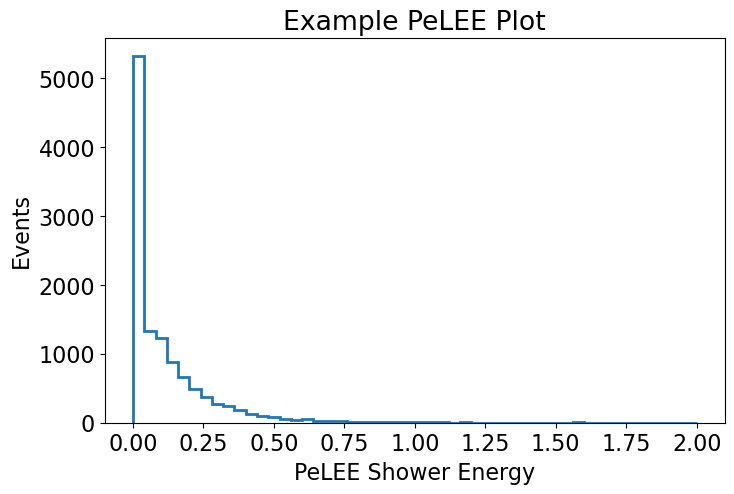

In [11]:
plt.rcParams.update({'font.size': 16})
lw=2

plt.figure(figsize=(8, 5))
plt.hist(all_df["wc_numu_score"], weights=all_df["net_weight"], bins=50, range=(-5, 5), histtype="step", lw=lw)
plt.xlabel(r"Wire-Cell $\nu_\mu$CC BDT Score")
plt.ylabel("Events")
plt.title("Example Wire-Cell Plot")
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(all_df["nblips_saved"], weights=all_df["net_weight"], bins=50, histtype="step", lw=lw)
plt.xlabel(r"Number of Blips Saved")
plt.ylabel("Events")
plt.title("Example Blip Plot")
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(all_df["pelee_shr_energy"], weights=all_df["net_weight"], bins=50, range=(0, 2), histtype="step", lw=lw)
plt.xlabel(r"PeLEE Shower Energy")
plt.ylabel("Events")
plt.title("Example PeLEE Plot")
plt.show()
